## Milestone 2
### Author: Emily McAfee
#### Faulty product identification

In [1]:
# Import packages
# Data cleaning/exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Smote
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Forward feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# LASSO & ridge regression
from sklearn import linear_model

Read and merge data

In [2]:
# Load in data
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secomdf = pd.read_csv(filename, sep = " ", header = None)

In [3]:
# Load in labels
filename2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secomlabels = pd.read_csv(filename2, sep = " ", header = None)

In [4]:
# Check data
secomdf.head()

0        1          2          3       4      5         6       7    \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

      8       9    ...     580       581     582     583     584      585  \
0  1.5005  0.0162  ...     NaN       NaN  0.5005  0.0118  0.0035   2.3630   
1  1.4966 -0.0005  ...  0.0060  208.2045  0.5019  0.0223  0.0055   4.4447   
2  1.4436  0.0041  ...  0.0148   82.8602  0.4958  0.0157  0.0039   3.1745   
3  1.4882 -0.0124  ...  0.0044   73.8432  0.4990  0.0103  0.0025   2.0544   
4  1.5031 -0.0031  ...     NaN       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  
0     NaN     NaN     NaN       NaN  
1  0.0096  0.0201  0.0060  208.2045  
2  0.0584  0.0484  0.0148   82.8602  
3  0.0202  0.0149  0.0044   73.8432  
4  0.0202  0.0149  0.0044   73.8432  

[5 rows x 590 columns]

In [5]:
# Check labels
secomlabels.head()

0                    1
0 -1  19/07/2008 11:55:00
1 -1  19/07/2008 12:32:00
2  1  19/07/2008 13:17:00
3 -1  19/07/2008 14:43:00
4 -1  19/07/2008 15:22:00

In [6]:
# Work with labels data
# Rename label columns
secomlabels.columns = ['class', 'datetime']

# Check data
secomlabels.head()

class             datetime
0     -1  19/07/2008 11:55:00
1     -1  19/07/2008 12:32:00
2      1  19/07/2008 13:17:00
3     -1  19/07/2008 14:43:00
4     -1  19/07/2008 15:22:00

In [7]:
# Bring together both original dataframe and labels dataframe
newdf = pd.concat([secomdf, secomlabels], axis = 1)

#Check new df
print(newdf.dtypes)
print(newdf.head())

0           float64
1           float64
2           float64
3           float64
4           float64
             ...   
587         float64
588         float64
589         float64
class         int64
datetime     object
Length: 592, dtype: object
         0        1          2          3       4      5         6       7  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

        8       9  ...     582     583     584      585     586     587  \
0  1.5005  0.0162  ...  0.5005  0.0118  0.0035   2.3630     NaN     NaN   
1  1.4966 -0.0005  ...  0.5019  0.0223  0.0055   4.4447  0.0096  0.0201   
2  1.4436  0.0041  ...  0.4958  0.0157  0.0039   3.1745  0.

Clean and prepare data

In [8]:
# Make datetime object
newdf.datetime = pd.to_datetime(newdf.datetime, format = '%d/%m/%Y %H:%M:%S')

# Check dtypes
newdf.dtypes


0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
                 ...      
587                float64
588                float64
589                float64
class                int64
datetime    datetime64[ns]
Length: 592, dtype: object

In [9]:
newdf2 = newdf.copy()
# Make datetime the index so that it is not treated as a feature
newdf2.set_index('datetime', inplace = True)

# Check data
newdf2.head()

0        1          2          3       4      5  \
datetime                                                                     
2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

                            6       7       8       9  ...       581     582  \
datetime                                               ...                     
2008-07-19 11:55:00   97.6133  0.1242  1.5005  0.0162  ...       NaN  0.5005   
2008-07-19 12:32:00  102.3433  0.1247  1.4966 -0.0005  ...  208.2045  0.5019   
2008-07-19 13:17:00   95.4878  0.1241  1.4436  0.0041  ...   82.8602  0.4958   
2008-07-19 14:43:00  104.2367  0.1217  1.4882 -0.0124  ...   73.8432  0.4990   
2008-07-19 15:22:00  100.3967  0.1235  1.5031 -0.0031  ...       NaN  0.4800   

                        583     584      585     586     587     588  \
datetime                                                               
2008-07-19 11:55:00  0.0118  0.0035   2.3630     NaN     NaN     NaN   
2008-07-19 12:32:00  0.0223  0.0055   4.4447  0.0096  0.0201  0.0060   
2008-07-19 13:17:00  0.0157  0.0039   3.1745  0.0584  0.0484  0.0148   
2008-07-19 14:43:00  0.0103  0.0025   2.0544  0.0202  0.0149  0.0044   
2008-07-19 15:22:00  0.4766  0.1045  99.3032  0.0202  0.0149  0.0044   

                          589  class  
datetime                              
2008-07-19 11:55:00       NaN     -1  
2008-07-19 12:32:00  208.2045     -1  
2008-07-19 13:17:00   82.8602      1  
2008-07-19 14:43:00   73.8432     -1  
2008-07-19 15:22:00   73.8432     -1  

[5 rows x 591 columns]

In [10]:
# See how many NaNs are in the dataframe
sum(len(newdf2) - newdf2.count())

# See how many non-non values there are 
sum(newdf2.count())

# See how many datapoints in all
(sum(len(newdf2) - newdf2.count())) + (sum(newdf2.count()))

926097

In [11]:
# Seems like there's not too many NaNs - we'll impute the mean for them
newdf3 = newdf2.fillna(newdf2.mean())
newdf3.head()

0        1          2          3       4      5  \
datetime                                                                     
2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

                            6       7       8       9  ...         581  \
datetime                                               ...               
2008-07-19 11:55:00   97.6133  0.1242  1.5005  0.0162  ...   97.934373   
2008-07-19 12:32:00  102.3433  0.1247  1.4966 -0.0005  ...  208.204500   
2008-07-19 13:17:00   95.4878  0.1241  1.4436  0.0041  ...   82.860200   
2008-07-19 14:43:00  104.2367  0.1217  1.4882 -0.0124  ...   73.843200   
2008-07-19 15:22:00  100.3967  0.1235  1.5031 -0.0031  ...   97.934373   

                        582     583     584      585       586       587  \
datetime                                                                   
2008-07-19 11:55:00  0.5005  0.0118  0.0035   2.3630  0.021458  0.016475   
2008-07-19 12:32:00  0.5019  0.0223  0.0055   4.4447  0.009600  0.020100   
2008-07-19 13:17:00  0.4958  0.0157  0.0039   3.1745  0.058400  0.048400   
2008-07-19 14:43:00  0.4990  0.0103  0.0025   2.0544  0.020200  0.014900   
2008-07-19 15:22:00  0.4800  0.4766  0.1045  99.3032  0.020200  0.014900   

                          588         589  class  
datetime                                          
2008-07-19 11:55:00  0.005283   99.670066     -1  
2008-07-19 12:32:00  0.006000  208.204500     -1  
2008-07-19 13:17:00  0.014800   82.860200      1  
2008-07-19 14:43:00  0.004400   73.843200     -1  
2008-07-19 15:22:00  0.004400   73.843200     -1  

[5 rows x 591 columns]

In [12]:
# Change class to 0 and 1
newdf3['class'] = newdf3['class'].replace(-1,0)
newdf3['class'].value_counts()

0    1463
1     104
Name: class, dtype: int64

Visually explore data

In [13]:
%time newdf.mean()

CPU times: user 564 ms, sys: 30.5 ms, total: 594 ms
Wall time: 513 ms


0        3014.452896
1        2495.850231
2        2200.547318
3        1396.376627
4           4.197013
            ...     
586         0.021458
587         0.016475
588         0.005283
589        99.670066
class      -0.867262
Length: 591, dtype: float64

In [14]:
# Explore data by each day
byday = newdf3.iloc[:,:590].groupby(pd.Grouper(freq = 'D')).mean()
byday

0            1            2            3         4    \
datetime                                                                   
2008-07-19  3001.863333  2515.117500  2219.899067  1272.050808  1.133158   
2008-07-20  2920.070000  2507.400000  2195.122200  1046.146800  1.320400   
2008-07-21  3007.705000  2579.375000  2204.527750   912.700250  1.379600   
2008-07-22  3010.836667  2528.990000  2230.320870  1163.552705  1.839102   
2008-07-23  3008.361448  2489.650000  2207.388900   962.531700  1.204300   
...                 ...          ...          ...          ...       ...   
2008-10-13  3031.895000  2494.392727  2193.725759  1680.836595  1.343614   
2008-10-14  2975.995000  2494.285000  2193.480556  1803.461906  1.428419   
2008-10-15  3032.822353  2489.346471  2198.327441  1788.045859  1.458500   
2008-10-16  3010.397368  2487.866316  2197.147374  1779.726811  1.450268   
2008-10-17  2939.550000  2454.183333  2192.925900  1736.134867  1.331333   

              5           6         7         8         9    ...       580  \
datetime                                                     ...             
2008-07-19  100.0  101.899450  0.122492  1.509575  0.002892  ...  0.006657   
2008-07-20  100.0  103.340000  0.122300  1.531000 -0.025900  ...  0.003400   
2008-07-21  100.0  106.360000  0.121850  1.485500 -0.003250  ...  0.006898   
2008-07-22  100.0  104.568451  0.120817  1.542600 -0.004483  ...  0.004681   
2008-07-23  100.0  104.031100  0.121000  1.551200  0.009850  ...  0.004900   
...           ...         ...       ...       ...       ...  ...       ...   
2008-10-13  100.0  100.282014  0.122995  1.377550  0.013550  ...  0.005671   
2008-10-14  100.0   97.645219  0.123462  1.379981 -0.000238  ...  0.006730   
2008-10-15  100.0   99.164753  0.123735  1.374421  0.001065  ...  0.005040   
2008-10-16  100.0  100.191516  0.123916  1.375332 -0.000974  ...  0.005126   
2008-10-17  100.0   94.437033  0.121867  1.462641 -0.002961  ...  0.004833   

                   581       582       583       584        585       586  \
datetime                                                                    
2008-07-19   94.412627  0.496558  0.055950  0.012800  11.536283  0.026955   
2008-07-20   52.203900  0.495000  0.015300  0.004100   3.092600  0.018800   
2008-07-21  120.421186  0.505550  0.012250  0.003200   2.427300  0.019500   
2008-07-22   87.222520  0.501217  0.011567  0.003133   2.307733  0.019733   
2008-07-23   74.506600  0.496200  0.012550  0.003900   2.528900  0.021250   
...                ...       ...       ...       ...        ...       ...   
2008-10-13  154.162496  0.500364  0.015855  0.003945   3.171818  0.013218   
2008-10-14   96.332920  0.501119  0.017344  0.004181   3.452631  0.022219   
2008-10-15   95.097128  0.499485  0.016097  0.003876   3.220874  0.019032   
2008-10-16  121.861550  0.499653  0.014874  0.003837   2.978737  0.017611   
2008-10-17   91.600533  0.499267  0.017067  0.003967   3.417567  0.019200   

                 587       588         589  
datetime                                    
2008-07-19  0.020356  0.006549   88.055781  
2008-07-20  0.009800  0.003400   52.203900  
2008-07-21  0.019350  0.005900   97.555950  
2008-07-22  0.014050  0.003917   73.481400  
2008-07-23  0.017300  0.004900   74.506600  
...              ...       ...         ...  
2008-10-13  0.019782  0.006459  236.893368  
2008-10-14  0.021419  0.006975   99.062931  
2008-10-15  0.015521  0.005132   97.868512  
2008-10-16  0.015921  0.005179  126.908100  
2008-10-17  0.016433  0.004833   91.600533  

[91 rows x 590 columns]

(array([733238., 733255., 733269., 733286., 733300., 733316., 733330.]),
 <a list of 7 Text xticklabel objects>)

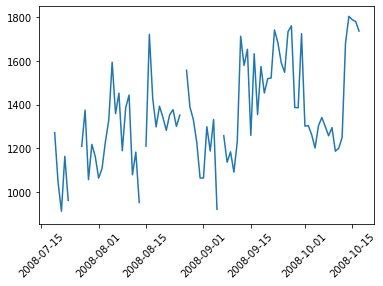

In [15]:
# Plot column 3 by day
plt.plot(byday.index, byday.iloc[:,3])
plt.xticks(rotation=45)

In [16]:
# Plot 3 random days and count how many 0s, 1s
# Pick 3 random days
byday.sample(3)

# Pull all these days from full df (based off of original iteration of 'sample')
begoct = newdf3.loc['2008-10-04']
endaug = newdf3.loc['2008-08-22']
endjul = newdf3.loc['2008-07-20']

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on October 4th, 2008')

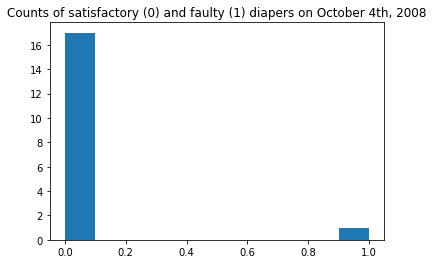

In [17]:
# begoct
plt.hist(begoct['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on October 4th, 2008')

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on August 22nd, 2008')

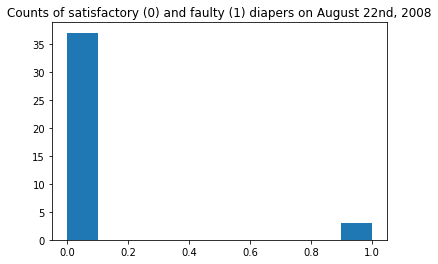

In [18]:
# endaug
plt.hist(endaug['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on August 22nd, 2008')

Text(0.5, 1.0, 'Counts of satisfactory (0) and faulty (1) diapers on July 20th, 2008')

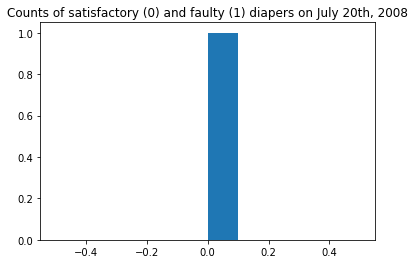

In [19]:
# endjul
plt.hist(endjul['class'])
plt.title('Counts of satisfactory (0) and faulty (1) diapers on July 20th, 2008')

### 1. Split prepared data from Milestone 1 into training and testing

In [20]:
# Establish features
x = newdf3.loc[:, newdf3.columns != 'class']

# Establish target label (variable we are trying to predict)
y = newdf3['class']

Handle class imbalance problem

In [21]:
# Apply SMOTE for class imbalance
# What did the imbalance look like before SMOTE
print('Original dataset shape {}'.format(Counter(y)))

# Apply SMOTE
sm = SMOTE(random_state = 42)
x_res, y_res = sm.fit_sample(x,y)

# What does the imbalance look like after SMOTE
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 1463, 1: 104})
Resampled dataset shape Counter({0: 1463, 1: 1463})


In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size = 0.2)

### 2. Build a decision tree model that detects faulty products

In [23]:
# Generate and evaluate the model
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(min_samples_leaf = 3).fit(x_train, y_train)

y_pred = model.predict(x_test)

In [24]:
# Examine Accuracies
from sklearn.metrics import accuracy_score
print('Decision Tree Model Accuracy: ', accuracy_score(y_test, y_pred)*100)


Decision Tree Model Accuracy:  90.27303754266211


### 3. Build an ensemble model that detects faulty products

In [25]:
# Split the data
x1_train, x1_test, y1_train, y1_test = train_test_split(x_res, y_res, test_size = .2)

In [26]:
# Train the random forest model
from sklearn.ensemble import RandomForestClassifier

# Establish parameters
nTrees = 13
max_depth = 12
min_node_size = 9
verbose = 0

# Initiate/fit model
clf = RandomForestClassifier(n_estimators = nTrees, max_depth = max_depth, random_state = 1, verbose = verbose, min_samples_leaf = min_node_size)
clf.fit(x1_train, y1_train)
#print(clf.feature_importances_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [27]:
# Predict testing data
y_rf_pred = clf.predict(x1_test)

# Find Accuracy
print('Random Forest Model Accuracy: ', accuracy_score(y1_test, y_rf_pred)*100)

Random Forest Model Accuracy:  94.53924914675767


### 4. Build an SVM model

In [42]:
# We already split the data so we will just use what we already have
# x_res
# y_res

# Set hyperparameters
# default is 1
cost = .7

# soften
gamma = 4

# Split data (so we can nname it new variables)
x2_train, x2_test, y2_train, y2_test = train_test_split(x_res, y_res, test_size = .2)

In [48]:
# Create Linear SVC
from sklearn import svm, metrics
from sklearn.metrics import classification_report

svcmodel = svm.LinearSVC(C = cost). fit(x2_train, y2_train)
svcmodel.predict(x2_test)
print('LinearSVC')
print(classification_report(svcmodel.predict(x2_test), y2_test))
# Predict testing data
y_svc_pred = svcmodel.predict(x2_test)

LinearSVC
              precision    recall  f1-score   support

           0       0.96      0.53      0.68       539
           1       0.12      0.72      0.20        47

    accuracy                           0.54       586
   macro avg       0.54      0.63      0.44       586
weighted avg       0.89      0.54      0.64       586



/Users/e.kubicek/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### 5. Evaluate all three models

In [49]:
print('Decision Tree Model Accuracy: ', accuracy_score(y_test, y_pred)*100)
print('Random Forest Model Accuracy: ', accuracy_score(y1_test, y_rf_pred)*100)
print('LinearSVC Model Accuracy: ', accuracy_score(y2_test, y_svc_pred)*100)

Decision Tree Model Accuracy:  90.27303754266211
Random Forest Model Accuracy:  94.53924914675767
LinearSVC Model Accuracy:  54.26621160409556
